In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt
from clawpack import riemann
from clawpack import pyclaw
import numpy as np

def qborder(t):
    """
    The boundary value at the left border x = 0. Here g(t) = sin²(pi t/4)
    """
    if 0<= t <= 8:
        q = np.sin(np.pi*t/4)**2
    else:
        q = 0.
        
    return q

def inlet_bc(state,dim,t,qbc,auxbc,num_ghost):
    """
    inlet boundary condition
    """
    dx = state.problem_data['dx']
    a  = state.problem_data['a']
    qbc[0, :num_ghost] = qborder(t)

def qinit(x):
    """
    The initial value.  
    """    
    if isinstance(x,(np.ndarray,list)):
        m = np.size(x)
        q = np.empty((m))
        for i in range(m):
            q[i] = 0
    if isinstance(x,(float,int)):
        q = 0
    return q

def qsol(x,t,a):
    """
    exact solution for n = 1
    """  
    if isinstance(x,(np.ndarray,list)):
        dim = np.size(x)
        q = np.zeros(dim)
        for i in range(dim):
            if x[i] < a*t:
                q[i] =  qborder(-x[i]/a+t) 
            else:
                q[i] = 0
    else:
        if x < a*t:
            q = qborder(-x/a+t)
        else:
            q = 0
    return q


def Solveur(q_l,q_r,aux_l,aux_r,problem_data):
    r"""
    1d solver with flux f = a u^n with n>=1
    """

    num_eqn = 1
    num_waves = 1

    # Convenience
    num_rp = q_l.shape[1]

    # Return values
    wave = np.empty( (num_eqn, num_waves, num_rp) )
    s    = np.empty( (num_waves, num_rp) )
    amdq = np.empty( (num_eqn, num_rp) )
    apdq = np.empty( (num_eqn, num_rp) )

    # Local values
    delta = np.empty(np.shape(q_l))
    delta = q_r - q_l
    
    n = problem_data['n']
    a = problem_data['a']
    
    # Compute the wave
    # 1-Wave
    wave[0,0,:] = delta
    
    if n>1:
        for i in range(num_rp):
            if q_r[0,i] != q_l[0,i]:
                s[0,i] =   a * (q_r[0,i]**n - q_l[0,i]**n)/(q_r[0,i]  - q_l[0,i])
            else:
                s[0,i] = 0
    else:
        s[0,:] = a * np.ones(num_rp)
    
    # Compute the left going and right going fluctuations
    s_index = np.zeros((2,num_rp))
    s_index[0,:] = s[0,:]
    amdq[0,:] = np.min(s_index,axis=0) * wave[0,0,:]
    apdq[0,:] = np.max(s_index,axis=0) * wave[0,0,:]
        
    # Compute entropy fix
    if problem_data['efix']:
        transonic = (q_l[0,:] < 0.0) * (q_r[0,:] > 0.0)
        amdq[0,transonic] = -a * q_l[0,transonic]**n
        apdq[0,transonic] =  a * q_r[0,transonic]**n

    return wave, s, amdq, apdq


def setup(L,mx,tf,nbs,a,n):
    
    solver    = pyclaw.ClawSolver1D()
    solver.rp = Solveur
    solver.num_waves = 1
    solver.num_eqn   = 1
    solver.kernel_language = 'Python'
    solver.limiters        = pyclaw.limiters.tvd.superbee
    solver.bc_lower[0]     = pyclaw.BC.custom
    solver.user_bc_lower   = inlet_bc
    solver.bc_upper[0]     = pyclaw.BC.extrap
    solver.order           = 2 #1: Godunov, 2: Lax-Wendroff-LeVeque
    
    x = pyclaw.Dimension(0, L, mx, name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 1
    
    state = pyclaw.State(domain, num_eqn)
    
    state.problem_data['a']     = a
    state.problem_data['n']     = n
    state.problem_data['efix']  = True
    state.problem_data['dx']    = L/mx
    
    xc = domain.grid.x.centers
    
    state.q[0, :] = qinit(xc)
     
    claw = pyclaw.Controller()
    outdir        = './_output'
    output_style  = 1
    claw.solution = pyclaw.Solution(state, domain)
    claw.solver   = solver
    claw.outdir   = outdir
    claw.output_style = output_style
    
    claw.tfinal           = tf
    claw.num_output_times = nbs
    claw.keep_copy = True
    claw.verbosity = 0
 
    return claw

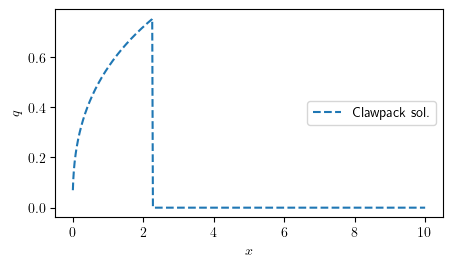

In [3]:
L = 10 ; mx = 1000 ; tf = 20 ; nbs = 50 ;  a = 1 ; n=3
claw = setup(L,mx,tf,nbs,a,n)
claw.run()

plt.rcParams['text.usetex'] = True
index = 10
frame = claw.frames[index]
dt    = claw.tfinal/claw.num_output_times
t     = dt*index
x     = frame.state.grid.c_centers
x     = x[0]
w     = frame.q[0,:]


fig, ax = plt.subplots(figsize=(5, 2.7))

ax.plot(x, w, '--',label='Clawpack sol.')

ax.legend(loc='right')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$q$')
plt.savefig("BIVP_linear-advection.pdf")

In [4]:
 
def burgers_animation():
    import matplotlib.animation
    import numpy
    # compute the solution with the method define above:
    #claw = setup()
    #claw.keep_copy = True
    #claw.run()
    x = claw.frames[0].grid.dimensions[0].centers
    x_true = numpy.linspace(0., L , mx)
 
    
    fig = plt.figure()
    axes = plt.subplot(1, 1, 1)
    plt.rcParams['text.usetex'] = True
    axes.set_xlabel(r'$x$',fontsize=14)
    axes.set_ylabel(r'$u(x, t)$',fontsize=14)
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((0, 1.2))
    axes.set_title(" ")
    text = axes.text(5, 1.1, '')
    
    def init():

        q_true = qinit(x_true)
        computed_line, = axes.plot(x[0], claw.frames[0].q[0, :][0], 'r')
        exact_line, = axes.plot(x_true[0], q_true[0] , 'k--')
        return  (computed_line, exact_line)
    
    computed_line, exact_line = init()

    
    def fplot(n):
        tt = claw.frames[n].t
        q_true = qinit(x_true)
        computed_line.set_data([x,], [claw.frames[n].q[0, :]])
        exact_line.set_data([x_true], [q_true ])
        val = f'{tt:.2f}'
        text.set_text(r'$ t = {} $ s'.format(val))
        return (computed_line, exact_line)

    frames_to_plot = range(0, len(claw.frames))
    plt.close(fig)
    return matplotlib.animation.FuncAnimation(fig, fplot, frames=frames_to_plot, interval=100,
                                   blit=True, init_func=None, repeat=False)

from IPython.display import HTML 
anim = burgers_animation()
HTML(anim.to_jshtml())

In [ ]:
# Export mp4
anim.save('KinematicWave_nonlinear.mp4',fps=5,writer="ffmpeg",dpi=300)
 
    

In [5]:
# Plotting the frames at different times
nsimul=np.size(claw.frames)
figs = []
for i in range(nsimul):
    L = 10
    hmin = 0
    hmax = 1
    fig, axes = plt.subplots(figsize=(5, 3))
    
    plt.rcParams['text.usetex'] = True
    axes.set_xlabel(r'$x$',fontsize=14)
    axes.set_ylabel(r'$u(x, t)$',fontsize=14)
    axes.set_xlim((0,L))
    axes.set_ylim(( hmin, hmax))
    text = axes.text(L/2, hmin+0.8*(hmax-hmin)  , '')
    
    frame = claw.frames[i]
    w  = frame.q[0,:]
    x  = frame.state.grid.c_centers
    x  = x[0]
    dt = claw.tfinal/claw.num_output_times
    t  = dt*i
    val= f'{t:.2f}'
    text.set_text(r'$  t = {} s$  '.format(val)) 
    plt.plot(x, w)
   
    figs.append(fig)
    plt.close(fig)
    
from clawpack.visclaw import animation_tools
animation_tools.interact_animate_figs(figs)  

interactive(children=(IntSlider(value=0, description='frameno', max=50), Output()), _dom_classes=('widget-inte…

In [9]:
# Exporting the frames for latex
import os
from os.path import expanduser
# Finding the home and current directories
home = expanduser("~")
cwd = os.getcwd()
user_directory = cwd

newdir = 'NonlinearAdvection_Snapshots'
if not os.path.isdir(newdir): os.mkdir(user_directory+"/"+newdir)
for i in range(len(figs)):
    figs[i].savefig(user_directory+'/'+newdir+'/Frame'+str(i)+'.png', bbox_inches='tight',dpi=300)